# Project Description

The goal of this project is to breakdown and create visual representations (via Tableau) of the transfer business that Manchester United F.C have carried out in the Premier League era (1992 - 2020). The dataset used in this project has been obtained from (source) and contains player movement information (loans, transfers, retirements, academy to first team promotions, player releases etc) on all teams that have played in the Premier Leagues. The key objectives of this analysis are as follows : 

1. Breakdown the no of transfers (loans vs fee based transfers vs free transfers);
2. Demographics of players involved in transfers;
3. Identify the clubs MUFC has dealt with;
4. Create a visual mapping of the transfers (Use Tableau to convert data from a tabular form to one where user has more interactability options)
5. Transfer fee aggregate informations;


**Caveats in Dataset:**

1. In the original dataset, player incomings and outgoings have been recorded in multiple different ways. They are as follows:  
- Player transferred in from another club (Permanent transfers involving a fee, Free transfers, Loan transfers (with and without fees).
- Player transferred out to another club (Permanent transfers involving a fee, Free transfers, Loan transfers (with and without fees).
- Players returning back to parent club after completing a loan spell (End of Loan Period).
- Players promoted to first team from youth squads(Under18's, Under21's, Under23's, Reserves etc) within the same club.
- Player Retirements, Career Breaks.
- Player Released (recorded as 'Without Club' in dataset) from club.

2. For analysis purposes, promotions to senior team from youth teams within same club, retirements and careerbreaks have not been considered as appropriate data points for this project and hence will be omitted.
3. For players joining a new club on loan the transfer type in indicated as "Loan Transfer" and for players returning/departing the club after completion of loan spell, the transfer type is indicated as "End of Loan".
4. For the player outgoings of Mufc, dataset only contains transfer information pertaining to players registered with the first team squad (of Manchester United). Loans from youth teams are not recorded.


**Assumptions:**

1. Stadium Coordinates have been used as location markers for the clubs. These are to be used to map transfer movements in Tableau.
2. For player transfers missing fee information in the original data source, information from news articles has been used to fill in these missing data points.  


**Data Source Citations:**

1. Transfer Market Info (https://github.com/ewenme/transfers)
2. Player Nationality Data (https://www.worldfootball.net/)
3. Most Recent Transfer Data - Summer-2022 (https://www.transfermarkt.co.in/manchester-united/transfers/verein/985)
4. Club Geolocation ( Manually generated using Google Maps)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Data Exploration

In [2]:
epl = pd.read_csv(r"C:\Users\Sasidharan\Desktop\Data Science Projects\Data Visualization Project\premier-league.csv")

In [3]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [4]:
epl.shape

(22975, 12)

In [5]:
epl.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,Middlesbrough FC,Tommy Wright,26.0,Left Winger,Leicester,€910Th.,in,Summer,0.91,Premier League,1992,1992/1993
1,Middlesbrough FC,Jonathan Gittens,28.0,defence,Southampton,€250Th.,in,Summer,0.25,Premier League,1992,1992/1993
2,Middlesbrough FC,Chris Morris,28.0,Right-Back,Celtic,?,in,Summer,NaN,Premier League,1992,1992/1993
3,Middlesbrough FC,Ben Roberts,17.0,Goalkeeper,Boro U18,-,in,Summer,NaN,Premier League,1992,1992/1993
4,Middlesbrough FC,Andy Todd,17.0,Centre-Back,Boro U18,-,in,Summer,NaN,Premier League,1992,1992/1993


In [6]:
# List of all Clubs that have played in the league

print(sorted(epl.club_name.unique().tolist()))

['AFC Bournemouth', 'Arsenal FC', 'Aston Villa', 'Barnsley FC', 'Birmingham City', 'Blackburn Rovers', 'Blackpool FC', 'Bolton Wanderers', 'Bradford City', 'Brentford FC', 'Brighton & Hove Albion', 'Burnley FC', 'Cardiff City', 'Charlton Athletic', 'Chelsea FC', 'Coventry City', 'Crystal Palace', 'Derby County', 'Everton FC', 'Fulham FC', 'Huddersfield Town', 'Hull City', 'Ipswich Town', 'Leeds United', 'Leicester City', 'Liverpool FC', 'Manchester City', 'Manchester United', 'Middlesbrough FC', 'Newcastle United', 'Norwich City', 'Nottingham Forest', 'Oldham Athletic', 'Portsmouth FC', 'Queens Park Rangers', 'Reading FC', 'Sheffield United', 'Sheffield Wednesday', 'Southampton FC', 'Stoke City', 'Sunderland AFC', 'Swansea City', 'Swindon Town', 'Tottenham Hotspur', 'Watford FC', 'West Bromwich Albion', 'West Ham United', 'Wigan Athletic', 'Wimbledon FC', 'Wolverhampton Wanderers']


In [7]:
# Record Purchase and Sale Details for each club;

def record(df,club):
    
    d = df.loc[df.club_name == club]
    
    
    # Record Player Purchase
    rb = d.loc[d['transfer_movement'] == 'in']
    rb = rb.loc[rb["fee_cleaned"] == max(rb["fee_cleaned"]) ]
    
    # Record Player Sale
    rs = d.loc[d['transfer_movement'] == 'out']
    rs = rs.loc[rs["fee_cleaned"] == max(rs["fee_cleaned"]) ]
    
    
    return pd.concat([rb,rs],axis = 0).reset_index(drop= True)

In [8]:
epl.isna().sum()

club_name                 0
player_name               0
age                      15
position                  0
club_involved_name        0
fee                       4
transfer_movement         0
transfer_period           0
fee_cleaned           14236
league_name               0
year                      0
season                    0
dtype: int64

# Data Cleaning

In [9]:
epl["fee"].fillna('NA',inplace=True)

In [10]:
epl.loc[(epl.club_name == "Manchester United") & (epl.fee == '-')]["club_involved_name"].unique()

array(['Man Utd U18', 'Man Utd Res.', 'Retired', 'Huddersfield',
       'Without Club', 'Career break', 'Man Utd U21', 'Man Utd U23'],
      dtype=object)

In [11]:
# Clubwise transfer data 

def clubdata(df, club):
    
    df = df.loc[df.club_name == club]
    
    # Dropping Player returns and depatrures after completion of loan spell
    #df.drop(df.loc[lambda x : x.fee.str.contains('End')].index,inplace=True)
    
    # Dropping Player promotions from youth teams within same club
    df.drop(df.loc[lambda x : x["club_involved_name"].str.contains('Man Utd U18|Man Utd U21|Man Utd U23|Man Utd Res.')].index,inplace=True)
    
    # Dropping Player Retirements,Career Break, Release from club
    df.drop(df.loc[lambda x : x["club_involved_name"].str.contains('Retired|Career break|Without Club')].index,inplace=True)
    
    #df.drop(df.loc[lambda x : x.fee.str.contains('-')].index,inplace=True)
    
    # Permanent transfers with unknown fee have been recorded as'?' in the column 'fee' 
    df["fee"] = df.fee.str.replace("?","Permanent Transfer")
    
    # Permanent transfers with a fee have been recorded as '€...m' in the column 'fee'
    df.loc[lambda x : x.fee.str.startswith("€"),"fee"] = "Permanent Transfer"
    
    # Loan transfers with a fee have been recorded as 'Loan fee...' in the column 'fee'
    df.loc[lambda x : x.fee.str.startswith("L"),"fee"] = "Loan Transfer"
    
    # Free transfers have been recorded as 'free' in the column 'fee'
    df.loc[lambda x : x.fee.str.startswith("f"),"fee"] = "Free Transfer"
    
    # Loan transfers without a fee have been recorded as 'loan transfer' in the column 'fee'
    df.loc[lambda x : x.fee.str.startswith("l"),"fee"] = "Loan Transfer"
    
    # End of Loan transfers have been recorded as 'End of loan....' in the column 'fee'
    df.loc[lambda x : x.fee.str.startswith("End"),"fee"] = "End of Loan"
    
    
    df.rename(columns = {'fee': 'Transfer Type','fee_cleaned':'Fee(Mill€)'},inplace = True)
    df.columns = [x.capitalize() for x in df.columns]
    return df

# Data Transformations

In [12]:
mufc = clubdata(epl,"Manchester United").reset_index(drop = True)

In [13]:
# Upon refering to wikipedia info, this data point has been determined as  player return to parent club after completion of loan spell and will be omitted

mufc.loc[mufc["Transfer type"] == '-']

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season
91,Manchester United,Ben Thornley,23.0,Left Winger,Huddersfield,-,in,Summer,NaN,Premier League,1997,1997/1998


In [14]:
mufc.loc[mufc.Player_name == "Ben Thornley"]

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season
59,Manchester United,Ben Thornley,20.0,Left Winger,Stockport,End of Loan,in,Winter,NaN,Premier League,1995,1995/1996
62,Manchester United,Ben Thornley,20.0,Left Winger,Stockport,Loan Transfer,out,Winter,NaN,Premier League,1995,1995/1996
63,Manchester United,Ben Thornley,20.0,Left Winger,Huddersfield,Loan Transfer,out,Winter,NaN,Premier League,1995,1995/1996
91,Manchester United,Ben Thornley,23.0,Left Winger,Huddersfield,-,in,Summer,NaN,Premier League,1997,1997/1998
129,Manchester United,Ben Thornley,23.0,Left Winger,Huddersfield,Permanent Transfer,out,Summer,0.2,Premier League,1998,1998/1999


In [15]:
mufc.loc[(mufc.Player_name == "Ben Thornley") & (mufc.Year == 1997),"Transfer type"] = "End of Loan"   

# 1. Player Nationality Data

In [16]:
# Manchester United Player Database obtained from https://www.worldfootball.net/ through excel (Tabular Data)

mufc_db = pd.read_csv(r"C:\Users\Sasidharan\Desktop\Data Science Projects\Data Visualization Project\Manutd Player Database.csv")

In [17]:
mufc_db.head()

,Player,Country,Unnamed: 2,Position,born
0,Peter Abbott,England,England,Forward,01-10-1953
1,Stan Ackerley,Australia,Australia,Defender,12-07-1942
2,Ted Adams,England,England,Goalkeeper,30-11-1906
3,Alphonso Ainsworth,England,England,Forward,31-07-1913
4,John Aitken,Scotland,Scotland,Forward,NaN


In [18]:
mufc.head()

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season
0,Manchester United,Dion Dublin,23.0,Centre-Forward,Cambridge Utd.,Permanent Transfer,in,Summer,1.500,Premier League,1992,1992/1993
1,Manchester United,Pat McGibbon,18.0,Centre-Back,Portadown,Permanent Transfer,in,Summer,0.225,Premier League,1992,1992/1993
2,Manchester United,Andy Arnott,18.0,Defensive Midfield,Gillingham FC,Loan Transfer,in,Summer,NaN,Premier League,1992,1992/1993
3,Manchester United,Danny Wallace,29.0,Attacking Midfield,Millwall,End of Loan,in,Summer,NaN,Premier League,1992,1992/1993
4,Manchester United,Mark Robins,22.0,Centre-Forward,Norwich,Permanent Transfer,out,Summer,1.000,Premier League,1992,1992/1993


In [19]:
import unicodedata

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


a = []
for name in list(mufc_db.Player):
    a.append(remove_accented_chars(name))
    
b = []
for name in list(mufc.Player_name):
    b.append(remove_accented_chars(name))

mufc_db["Player"] = a
mufc["Player_name"] = b

In [20]:
mufc_db.drop(columns=["Unnamed: 2","Position","born"],inplace=True)
mufc_db["Player"] = mufc_db.Player.str.replace("?","c")

In [21]:
player = []
nationality = []

for name in mufc.Player_name.unique():
    player.append(name)
    
    if name in list(mufc_db.Player):
        nationality.append(mufc_db[mufc_db.Player == name]["Country"].squeeze())      
        
    else:
        nationality.append('NA')

In [22]:
data = pd.DataFrame(list(zip(player,nationality)),columns = ["Player","Nationality"])
data["Nationality"] = data["Nationality"].astype('str')

We have obtained nationalities of most of the players. However, some data is still missing due to mismatches between the dataframes (due to usage of short names). The Manchester United player database is also missing players who did not make any appearances for the club.We will fill the nationalities of the missing players manually.

In [23]:
data.Nationality.unique()

array(['England', 'Northern Ireland', 'NA', 'Ireland', 'France', 'Wales',
       'Scotland',
       '487    England\n488    England\nName: Country, dtype: object',
       'Russia', 'Jamaica', 'Czech Republic', 'Netherlands', 'Norway',
       'Trinidad & Tobago', 'Sweden', 'Gibraltar', 'Australia', 'Italy',
       'Denmark', 'South Africa', 'Argentina', 'Uruguay', 'Spain',
       'Portugal', 'Brazil', 'USA', 'China', 'Serbia', 'Poland', 'Angola',
       'Bulgaria', 'Belgium', 'Ecuador', 'Senegal', 'Japan', 'Chile',
       'Ivory Coast', 'Colombia', 'Germany', 'Armenia', 'Nigeria'],
      dtype=object)

In [24]:
data.loc[data.Player == 'Lee Martin',"Nationality"] = "England"

In [25]:
p = data.loc[data.Nationality.astype('str') == 'NA']["Player"].unique()

print(p)

['Andy Arnott' 'Jason Lydiate' 'Kieran Toal' 'Richard Irving'
 'Ole Gunnar Solskjaer' 'Jovan Kirovski' 'Jody Banim' 'Robert Trees'
 'Stuart Brightwell' 'Kalam Mooniaruck' 'Kirk Hilton' 'Mike Clegg'
 'Hussein Yasser' 'Souleymane Mamam' 'Ben Muirhead' 'Andrew Taylor'
 'Eric Djemba Djemba' 'Danny Byrne' 'Matthew Williams' 'Gerard Pique'
 'Ji-sung Park' 'Phil Picken' 'David Poole' 'Steven Hogg' 'Michael Lea'
 'Scott Moffatt' 'Chicharito' 'Conor Devlin' 'David de Gea'
 'Frederic Veseli' 'Davide Petrucci' 'Juan Mata' 'Vanja Milinkovic-Savic'
 'Andy Kellett']


In [26]:
missing_nations = ['England','England','Ireland','England','Norway','USA','England','England','England','England',
                   'England','England','Qatar','Togo','England','England','Cameroon','England','Wales','Spain',
                   'South Korea','England','England','England','England','England','Mexico','Northern Ireland','Spain',
                   'Albania','Italy','Spain','Serbia','England']

In [27]:
mn = dict(zip(p,missing_nations))

In [28]:
for player in data.loc[data.Nationality == 'NA'].Player:
    data.loc[data.Player == player,"Nationality"] = mn[player]   

data.rename(columns = {'Player':'Player_name'},inplace=True)

In [29]:
mufc_v1 = pd.merge(mufc,data,how= 'inner',on='Player_name')

# 2. Updating new Transfers & Club Data (Nation of Origin, Location Coordinates Info)

In [30]:
mufc_v1.Club_involved_name.nunique()

201

In [31]:
# Grouping Clubs by Starting Alphabet

from itertools import groupby

club_list = sorted(mufc_v1.Club_involved_name.unique().tolist())
club_grouped = [list(g) for k, g in groupby(club_list, key=lambda x: x[0])]

keys = sorted(mufc_v1.Club_involved_name.str[0].unique().tolist())

club_dict  = dict(zip(keys,club_grouped))

In [32]:
print(club_dict)

{'1': ['1. FC Köln'], 'A': ['AC Merlan Lome', 'AC Milan', 'AC Parma', 'AC Venezia 1907', 'AEL Limassol', 'AS Roma', 'Aalesund', 'Aberdeen FC', 'Ajax', 'Al-Rayyan SC', 'Alavés', 'Altrincham', 'Arsenal', 'Aston Villa', 'Atalanta BC', 'Athletic', 'Atlético Madrid', 'Atlético-PR'], 'B': ['Barcelona', 'Barnsley FC', 'Barça U19', 'Bay. Leverkusen', 'Bayern Munich', 'Benfica', 'Besiktas', 'Birmingham', 'Blackburn', 'Blackpool', 'Boca Juniors', 'Bolton', 'Bor. Dortmund', 'Bournemouth', 'Bradford', 'Braintree', 'Brighton', 'Bristol Rovers', 'Brommapojkarna', 'Burnley', 'Bury'], 'C': ['CA Osasuna', 'CFR Cluj', 'CSKA Moscow', 'Cambridge Utd.', 'Cardiff', 'Carlisle United', 'Celta de Vigo', 'Celtic', 'Charlton', 'Chelsea', 'Chesterfield FC', 'Chicago', 'Chivas', 'Club Brugge', 'Colchester Utd.', 'Coventry', 'Crewe Alexandra', 'Crystal Palace'], 'D': ['DL Shide', 'Derby', 'Dinamo Moscow', 'Dinamo Zagreb', 'Doncaster'], 'E': ['E. Frankfurt', 'Estudiantes', 'Everton', 'Exeter City'], 'F': ['FC Nantes

In [33]:
# Club Country Mapping;


country_info = [ 
            ["Germany"],
            ["Togo","Italy","Italy","Italy","Cyprus","Italy","Norway","Scotland","Netherlands",
             "Qatar","Spain","England","England","England","Italy","Spain","Spain","Brazil"],
            ["Spain","England","Spain","Germany","Germany","Portugal","Turkey","England","England",
             "England","Argentina","England","Germany","England","England","England","England",
             "England","Sweden","England","England"],
            ["Spain","Romania","Russia","England","Wales","England","Spain","Scotland","England","England","England",
             "USA","Mexico","Belgium","England","England","England","England"],
            ["China","England","Russia","Croatia","England"],
            ["Germany","Argentina","England","England"],
            ["France","Portugal","Turkey","Italy","Brazil","Brazil","England"],
            ["France","England","Spain","England"],
            ["Germany","England","Scotland","Sweden","England","Scotland","England","England"],
            ["Sweden","Argentina","Italy","Brazil","England"],
            ["Italy"],
            ["Belgium","Scotland"],
            ["Ecuador","Italy","Poland","England","England","Scotland","Sweden","USA","England"],
            ["England","England","France","Australia","England","England","Norway","France","Scotland"],
            ["Netherlands","England","England","England","England","England"],
            ["France","England","France"],
            ["Netherlands","Greece","France","Italy","Serbia","Portugal","England","Angola",
             "Uruguay","England","England","Northern Ireland","England","England"],
            ["England"],
            ["Netherlands","Spain","Scotland","England","Spain","Spain","Spain","Spain","Serbia",
             "Italy","Portugal","England","England","Belgium"],
            ["Portugal","China","China","Italy","Italy","Brazil","England","Spain",
             "Ukraine","England","England","England","Czech Republic","England","Russia","Portugal",
             "England","Scotland","England","Belgium","England","England","England","Wales","England"],
            ["Italy","England","England"],
            ["Chile","England"],
            ["Spain","Germany","Norway","Spain","Portugal","Netherlands","Portugal","Serbia"],
            ["England","England","Germany","England","England","England","England","England","Wales","England"],
            ["England","England"]]

In [34]:
club_grouped = [y for x in club_grouped for y in x]
club_info = [y for x in country_info for y in x]

club_country_data = pd.DataFrame(list(zip(club_grouped,club_info)),columns = ["Club_involved_name","Club_involved_country"])

In [35]:
mufc_v2 = pd.merge(mufc_v1,club_country_data,how= 'inner',on='Club_involved_name')

In [36]:
mufc_v2["Club_involved_name"] = mufc_v2["Club_involved_name"].replace(['Parma'],'AC Parma')

In [37]:
# Mufc 2022-2023 Season summer transfers info obtained from https://www.transfermarkt.com/premier-league/transfers/wettbewerb/GB1

mufc_2022 = pd.read_csv(r"C:\Users\Sasidharan\Desktop\Data Science Projects\Data Visualization Project\Mufc_transfers_2023.csv")

In [38]:
mufc_2022.head()

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country
0,Manchester United,Christian Eriksen,30,Central Midfield,Brentford,Free Transfer,in,Summer,0.00,Premier League,2022,2022/2023,Denmark,England
1,Manchester United,Martin Dubravka,33,Goalkeeper,Newcastle,Loan Transfer,in,Summer,2.00,Premier League,2022,2022/2023,Slovenia,England
2,Manchester United,Antony,22,Right Winger,Ajax,Permanent Transfer,in,Summer,95.00,Premier League,2022,2022/2023,Brazil,Netherlands
3,Manchester United,Lisandro Martinez,24,Centre-Back,Ajax,Permanent Transfer,in,Summer,57.37,Premier League,2022,2022/2023,Argentina,Netherlands
4,Manchester United,Casemiro,30,Defensive Midfield,Real Madrid,Permanent Transfer,in,Summer,70.65,Premier League,2022,2022/2023,Brazil,Spain


In [39]:
mufc_v3 = mufc_v2.append(mufc_2022).reset_index(drop = True)

In [40]:
mufc_v3.tail(25)

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country
860,Manchester United,Tahith Chong,21.0,Right Winger,Club Brugge,End of Loan,in,Summer,NaN,Premier League,2021,2021/2022,Netherlands,Belgium
861,Manchester United,Amad Diallo,18.0,Right Winger,Atalanta BC,Permanent Transfer,in,Winter,21.30,Premier League,2020,2020/2021,Ivory Coast,Italy
862,Manchester United,Christian Eriksen,30.0,Central Midfield,Brentford,Free Transfer,in,Summer,0.00,Premier League,2022,2022/2023,Denmark,England
863,Manchester United,Martin Dubravka,33.0,Goalkeeper,Newcastle,Loan Transfer,in,Summer,2.00,Premier League,2022,2022/2023,Slovenia,England
864,Manchester United,Antony,22.0,Right Winger,Ajax,Permanent Transfer,in,Summer,95.00,Premier League,2022,2022/2023,Brazil,Netherlands
865,Manchester United,Lisandro Martinez,24.0,Centre-Back,Ajax,Permanent Transfer,in,Summer,57.37,Premier League,2022,2022/2023,Argentina,Netherlands
866,Manchester United,Casemiro,30.0,Defensive Midfield,Real Madrid,Permanent Transfer,in,Summer,70.65,Premier League,2022,2022/2023,Brazil,Spain
867,Manchester United,Tyrell Malacia,22.0,Left-Back,Feyenoord,Permanent Transfer,in,Summer,15.00,Premier League,2022,2022/2023,Netherlands,Netherlands
868,Manchester United,Axel Tuanzebe,24.0,Centre-Back,SSC Napoli,End of Loan,in,Summer,0.00,Premier League,2022,2022/2023,England,Italy
869,Manchester United,Anthony Martial,26.0,Centre-Forward,Sevilla FC,End of Loan,in,Summer,0.00,Premier League,2022,2022/2023,France,Spain


In [41]:
# Club Geo Location Information (Latitude and Longitude). Data  manually generated using stadium coordinates using info obtained from Google Maps;


club_info = pd.read_csv(r"C:\Users\Sasidharan\Desktop\Data Science Projects\Data Visualization Project\Club_info.csv")

In [42]:
club_info.head()

,Club_involved_name,Club_involved_location,Latitude,Longitude
0,1. FC Köln,Cologne,50.933497,6.874997
1,Aalesund,Alesund,62.46979,6.18704
2,Aberdeen FC,Aberdeen,57.15944,-2.0863
3,AC Merlan Lome,Lome,6.19732,1.23295
4,AC Milan,Milan,45.47785,9.12173


In [43]:
mufc_v4 = pd.merge(mufc_v3,club_info,how= 'inner',on='Club_involved_name') 

# 3. Fixing Column Inconsistencies (Positions)

In [44]:
# Player position categories include both specific as well as generic position labels. We will create two columns that mention each seperately;

mufc_v4["Position"].unique()

array(['Centre-Forward', 'Defensive Midfield', 'Central Midfield',
       'Centre-Back', 'Right Winger', 'Right Midfield', 'Right-Back',
       'Goalkeeper', 'Attacking Midfield', 'attack', 'Left-Back',
       'Left Winger', 'defence', 'Second Striker', 'Left Midfield',
       'midfield'], dtype=object)

In [45]:
# Replacing generic position labels with specific labels; (Obtained from web search)

mufc_v4[mufc_v4.Position == "attack"]

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude
46,Manchester United,Graeme Tomlinson,22.0,attack,Millwall,End of Loan,in,Winter,NaN,Premier League,1997,1997/1998,England,England,Bermondsey,51.48621,-0.05271
47,Manchester United,Graeme Tomlinson,22.0,attack,Millwall,Loan Transfer,out,Winter,NaN,Premier League,1997,1997/1998,England,England,Bermondsey,51.48621,-0.05271
62,Manchester United,Kalam Mooniaruck,15.0,attack,Norwich,Permanent Transfer,in,Summer,NaN,Premier League,1999,1999/2000,England,England,Norwich,52.622128,1.308653
71,Manchester United,Richard Irving,19.0,attack,Nottm Forest,Permanent Transfer,out,Summer,0.093,Premier League,1995,1995/1996,England,England,Nottingham,52.94,-1.132778
184,Manchester United,Graeme Tomlinson,21.0,attack,Bournemouth,End of Loan,in,Summer,NaN,Premier League,1997,1997/1998,England,England,Bournemouth,50.73387,-1.83905
185,Manchester United,Graeme Tomlinson,21.0,attack,Bournemouth,Loan Transfer,out,Summer,NaN,Premier League,1997,1997/1998,England,England,Bournemouth,50.73387,-1.83905
217,Manchester United,Graeme Tomlinson,20.0,attack,Luton,End of Loan,in,Summer,NaN,Premier League,1995,1995/1996,England,England,Luton,51.88398,-0.43062
218,Manchester United,Graeme Tomlinson,20.0,attack,Luton,Loan Transfer,out,Winter,NaN,Premier League,1995,1995/1996,England,England,Luton,51.88398,-0.43062
323,Manchester United,Graeme Tomlinson,18.0,attack,Bradford,Permanent Transfer,in,Summer,0.120,Premier League,1994,1994/1995,England,England,Bradford,53.80365,-1.76077
332,Manchester United,Graeme Tomlinson,22.0,attack,Macclesfield,Permanent Transfer,out,Summer,NaN,Premier League,1998,1998/1999,England,England,Macclesfield,53.24295,-2.12703


In [46]:
positions_f = {'Graeme Tomlinson' : 'Centre-Forward','Kalam Mooniaruck': 'Left Winger','Richard Irving':'Centre-Forward','Jody Banim': 'Centre-Forward'}

for x in positions_f.keys():
    mufc_v4.loc[(mufc_v4.Position == 'attack') & (mufc_v4.Player_name == x),'Position'] = positions_f[x] 

In [47]:
mufc_v4[mufc_v4.Position == "defence"]

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude
94,Manchester United,Jason Lydiate,20.0,defence,Bolton,Free Transfer,out,Summer,0.0,Premier League,1992,1992/1993,England,England,Horwich,53.580556,-2.535556
557,Manchester United,Danny Byrne,19.0,defence,Hartlepool,End of Loan,in,Winter,NaN,Premier League,2003,2003/2004,England,England,Hartlepool,54.68897,-1.21268
558,Manchester United,Danny Byrne,18.0,defence,Hartlepool,Loan Transfer,out,Winter,NaN,Premier League,2003,2003/2004,England,England,Hartlepool,54.68897,-1.21268
690,Manchester United,Danny Byrne,18.0,defence,Unknown,Permanent Transfer,in,Summer,NaN,Premier League,2003,2003/2004,England,England,NaN,na,na


In [48]:
positions_d = {'Jason Lydiate':'Right-Back','Danny Byrne':'Central Midfield'}

for y in positions_d.keys():
    mufc_v4.loc[(mufc_v4.Position == 'defence') & (mufc_v4.Player_name == y),'Position'] = positions_d[y] 

In [49]:
mufc_v4[mufc_v4.Position == "midfield"]

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude
147,Manchester United,Kieran Toal,21.0,midfield,Motherwell FC,Permanent Transfer,out,Winter,NaN,Premier League,1992,1992/1993,Ireland,Scotland,Motherwell,55.779947,-3.980078
205,Manchester United,Simon Davies,19.0,midfield,Exeter City,End of Loan,in,Winter,NaN,Premier League,1993,1993/1994,Wales,England,Exeter,50.73056,-3.5213
206,Manchester United,Simon Davies,19.0,midfield,Exeter City,Loan Transfer,out,Winter,NaN,Premier League,1993,1993/1994,Wales,England,Exeter,50.73056,-3.5213
207,Manchester United,Simon Davies,22.0,midfield,Huddersfield,Loan Transfer,out,Summer,NaN,Premier League,1996,1996/1997,Wales,England,Huddersfield,53.65416,-1.76879
208,Manchester United,Simon Davies,22.0,midfield,Huddersfield,End of Loan,in,Winter,NaN,Premier League,1996,1996/1997,Wales,England,Huddersfield,53.65416,-1.76879
216,Manchester United,Simon Davies,23.0,midfield,Luton,Permanent Transfer,out,Summer,0.30,Premier League,1997,1997/1998,Wales,England,Luton,51.88398,-0.43062
362,Manchester United,Michael Appleton,21.0,midfield,Preston,Permanent Transfer,out,Summer,0.76,Premier League,1997,1997/1998,England,England,Preston,53.77209,-2.68873
392,Manchester United,Michael Appleton,21.0,midfield,Grimsby Town,End of Loan,in,Winter,NaN,Premier League,1996,1996/1997,England,England,Cleethorpes,53.57049,-0.04671
393,Manchester United,Michael Appleton,21.0,midfield,Grimsby Town,Loan Transfer,out,Winter,NaN,Premier League,1996,1996/1997,England,England,Cleethorpes,53.57049,-0.04671
674,Manchester United,Andrew Taylor,19.0,midfield,Northwich Vic,Permanent Transfer,out,Summer,NaN,Premier League,2002,2002/2003,England,England,Norwich,53.27048,-2.48919


In [50]:
positions_m = {'Kieran Toal':'Central Midfield','Simon Davies':'Central Midfield','Michael Appleton':'Central Midfield','Andrew Taylor':'Central Midfield'}

for z in positions_m.keys():
    mufc_v4.loc[(mufc_v4.Position == 'midfield') & (mufc_v4.Player_name == z),'Position'] = positions_m[z] 

In [51]:
Midfield = ['Defensive Midfield','Central Midfield','Right Midfield','Attacking Midfield','Left Midfield']
Defence = ['Centre-Back','Right-Back','Left-Back']
Attack = ['Second Striker','Centre-Forward','Right Winger','Left Winger']
GoalKeeping = ['Goalkeeper']

def pos(x):
    if x in Midfield:
        return 'Midfield'
    elif x in Defence:
        return 'Defence'
    elif x in Attack:
        return 'Attack'
    else:
        return 'GoalKeeping'
    
mufc_v4["Overall_Position"] = mufc_v4["Position"].apply(lambda x: pos(x))

# 4. Handling Null Values

In [52]:
mufc_v4.isnull().sum()

Club_name                   0
Player_name                 0
Age                         3
Position                    0
Club_involved_name          0
Transfer type               0
Transfer_movement           0
Transfer_period             0
Fee(mill€)                530
League_name                 0
Year                        0
Season                      0
Nationality                 0
Club_involved_country       0
Club_involved_location      1
Latitude                    0
Longitude                   0
Overall_Position            0
dtype: int64

In [53]:
# Age

mufc_v4.loc[mufc_v4.Age.isna()]

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude,Overall_Position
105,Manchester United,Jimmy Davis,NaN,Left Winger,Swindon Town,End of Loan,in,Summer,NaN,Premier League,2002,2002/2003,England,England,Swindon,51.56463,-1.77182,Attack
106,Manchester United,Jimmy Davis,NaN,Left Winger,Swindon Town,Loan Transfer,out,Winter,NaN,Premier League,2002,2002/2003,England,England,Swindon,51.56463,-1.77182,Attack
614,Manchester United,Jimmy Davis,NaN,Left Winger,Watford,Permanent Transfer,out,Summer,NaN,Premier League,2003,2003/2004,England,England,Watford,51.649836,-0.401486,Attack


In [54]:
mufc_v4.loc[(mufc_v4.Age.isna()) & (mufc_v4.Year == 2002),'Age'] = 20.0
mufc_v4.loc[(mufc_v4.Age.isna()) & (mufc_v4.Year == 2003),'Age'] = 21.0

In [55]:
# Club Involved Location

mufc_v4.loc[mufc_v4.Club_involved_location.isna()]

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude,Overall_Position
690,Manchester United,Danny Byrne,18.0,Central Midfield,Unknown,Permanent Transfer,in,Summer,NaN,Premier League,2003,2003/2004,England,England,NaN,na,na,Midfield


In [56]:
# Since detailed information about this transfer is not available, this data point can be dropped

mufc_v4.drop(mufc_v4.loc[mufc_v4.Club_involved_location.isna()].index, inplace=True)

In [57]:
# Fee

mufc_v4.loc[mufc_v4["Fee(mill€)"].isna(),'Transfer type'].value_counts()

End of Loan           262
Loan Transfer         248
Permanent Transfer     19
Name: Transfer type, dtype: int64

In [58]:
mufc_v4.loc[(mufc_v4["Fee(mill€)"].isna()) & (mufc_v4["Transfer type"] == 'Loan Transfer'),"Fee(mill€)"] = 0
mufc_v4.loc[(mufc_v4["Fee(mill€)"].isna()) & (mufc_v4["Transfer type"] == 'End of Loan'),"Fee(mill€)"] = 0

In [59]:
mufc_v4.loc[(mufc_v4["Fee(mill€)"].isna()) & (mufc_v4["Transfer type"] == 'Permanent Transfer')]

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude,Overall_Position
49,Manchester United,Steve Bruce,35.0,Centre-Back,Birmingham,Permanent Transfer,out,Summer,NaN,Premier League,1996,1996/1997,England,England,Birmingham,52.47562,-1.86247,Defence
62,Manchester United,Kalam Mooniaruck,15.0,Left Winger,Norwich,Permanent Transfer,in,Summer,NaN,Premier League,1999,1999/2000,England,England,Norwich,52.622128,1.308653,Attack
147,Manchester United,Kieran Toal,21.0,Central Midfield,Motherwell FC,Permanent Transfer,out,Winter,NaN,Premier League,1992,1992/1993,Ireland,Scotland,Motherwell,55.779947,-3.980078,Midfield
148,Manchester United,Brian McClair,34.0,Centre-Forward,Motherwell FC,Permanent Transfer,out,Summer,NaN,Premier League,1998,1998/1999,Scotland,Scotland,Motherwell,55.779947,-3.980078,Attack
152,Manchester United,Lee Martin,25.0,Left-Back,Celtic,Permanent Transfer,out,Winter,NaN,Premier League,1993,1993/1994,England,Scotland,Glasgow,55.849711,-4.205589,Defence
183,Manchester United,Russell Beardsmore,24.0,Central Midfield,Bournemouth,Permanent Transfer,out,Summer,NaN,Premier League,1993,1993/1994,England,England,Bournemouth,50.73387,-1.83905,Midfield
199,Manchester United,Clayton Blackmore,29.0,Left-Back,Middlesbrough,Permanent Transfer,out,Summer,NaN,Premier League,1994,1994/1995,Wales,England,Middlesbrough,54.578333,-1.216944,Defence
200,Manchester United,Bryan Robson,37.0,Central Midfield,Middlesbrough,Permanent Transfer,out,Summer,NaN,Premier League,1994,1994/1995,England,England,Middlesbrough,54.578333,-1.216944,Midfield
332,Manchester United,Graeme Tomlinson,22.0,Centre-Forward,Macclesfield,Permanent Transfer,out,Summer,NaN,Premier League,1998,1998/1999,England,England,Macclesfield,53.24295,-2.12703,Attack
353,Manchester United,Craig Lawton,22.0,Left Midfield,Port Vale,Permanent Transfer,out,Summer,NaN,Premier League,1994,1994/1995,England,England,Stoke-On-Trent,53.04998,-2.19294,Midfield


In [60]:
# The following information was obtained from wikipedia & updated transfermakt stats; Will also change transfer type based on fee;

fee_info = {'Dylan Levitt': 0.4, 'Brian McClair': 0 , 'Kieran Toal' : 0, 'Steve Bruce' : 0, 'Russell Beardsmore' : 0,
           'Clayton Blackmore':0, 'Graeme Tomlinson':0, 'Craig Lawton':0,'Giuliano Maiorana':0,
           'Erik Nevland':0.35, 'Jimmy Davis' : 0}

free_transfers = ['Brian McClair','Kieran Toal','Steve Bruce','Russell Beardsmore','Clayton Blackmore','Graeme Tomlinson',
                 'Craig Lawton','Giuliano Maiorana']

for n in free_transfers:
     mufc_v4.loc[(mufc_v4["Fee(mill€)"].isna()) & (mufc_v4["Player_name"] == n),"Transfer type"] = "Free Transfer"
    

for p in fee_info.keys():
    mufc_v4.loc[(mufc_v4["Fee(mill€)"].isna()) & (mufc_v4["Player_name"] == p),"Fee(mill€)"] = fee_info[p]
    
mufc_v4.loc[(mufc_v4["Club_involved_name"] == "Watford") & (mufc_v4["Player_name"] == "Jimmy Davis"),"Transfer type"] = "Loan Transfer"

Fee information is not available for a 9 transfers in total; 

# 4. Mapping Transfer Movements (For Tableau Visualization Purposes)

In [61]:
mufc_v4.head()

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude,Overall_Position
0,Manchester United,Dion Dublin,23.0,Centre-Forward,Cambridge Utd.,Permanent Transfer,in,Summer,1.5,Premier League,1992,1992/1993,England,England,Cambridge,52.21293,0.1568,Attack
1,Manchester United,Grant Brebner,20.0,Defensive Midfield,Cambridge Utd.,End of Loan,in,Winter,0.0,Premier League,1997,1997/1998,Scotland,England,Cambridge,52.21293,0.1568,Midfield
2,Manchester United,Grant Brebner,20.0,Defensive Midfield,Cambridge Utd.,Loan Transfer,out,Winter,0.0,Premier League,1997,1997/1998,Scotland,England,Cambridge,52.21293,0.1568,Midfield
3,Manchester United,Colin Heath,21.0,Centre-Forward,Cambridge Utd.,End of Loan,in,Winter,0.0,Premier League,2004,2004/2005,England,England,Cambridge,52.21293,0.1568,Attack
4,Manchester United,Colin Heath,20.0,Centre-Forward,Cambridge Utd.,Loan Transfer,out,Winter,0.0,Premier League,2004,2004/2005,England,England,Cambridge,52.21293,0.1568,Attack


In [62]:
# Club to Club Mapping

mufc_v4["From_Club"] = np.where(mufc_v4["Transfer_movement"] == "in", mufc_v4["Club_involved_name"], mufc_v4["Club_name"])
mufc_v4["To_Club"] = np.where(mufc_v4["Transfer_movement"] == "out", mufc_v4["Club_involved_name"], mufc_v4["Club_name"])

# Data Analysis

# Transfer Counts breakdown

Players returns/departures wrt club after completion of loan spell are not considered in the following analysis as they are not organic data points by themselves; 

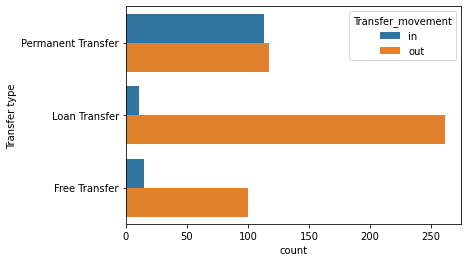

In [63]:
# 1. Transfer count breakdown by transfer type, transfer period, transfer movement type

ax = sns.countplot(y = "Transfer type", data = mufc_v4.loc[(mufc_v4["Transfer type"] != "End of Loan")], hue = "Transfer_movement")

In [64]:
mufc_v4.loc[(mufc_v4["Transfer type"] == "Loan Transfer") & (mufc_v4["Transfer_movement"] == "out"), "Age"].median()

20.0

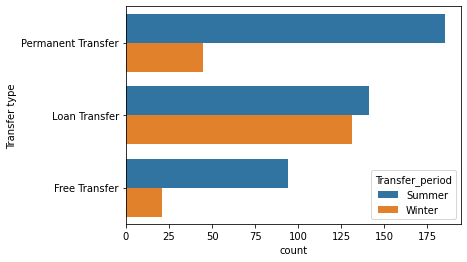

In [65]:
ax = sns.countplot(y = "Transfer type", data = mufc_v4.loc[(mufc_v4["Transfer type"] != "End of Loan")], hue = "Transfer_period")

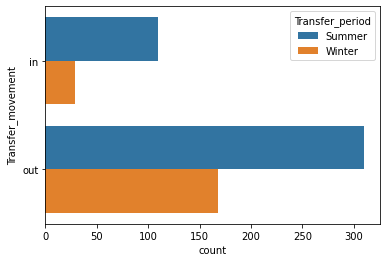

In [66]:
ax = sns.countplot(y = "Transfer_movement", data = mufc_v4.loc[(mufc_v4["Transfer type"] != "End of Loan")], hue = "Transfer_period")

# Player Nationality Info

In [67]:
# Count of Nationalities

mufc_v4["Nationality"].nunique()

46

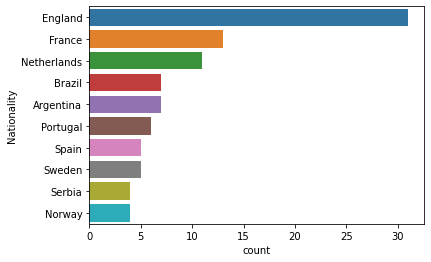

In [68]:
# 2. Player demographic breakdown
# a. Incoming Transfers
ax = sns.countplot(y = "Nationality", data = mufc_v4.loc[(mufc_v4.Transfer_movement == "in") & (mufc_v4["Transfer type"] != "End of Loan")], order = mufc_v4.loc[(mufc_v4.Transfer_movement == "in") & (mufc_v4["Transfer type"] != "End of Loan"),"Nationality"].value_counts(ascending = False)[:10].index)

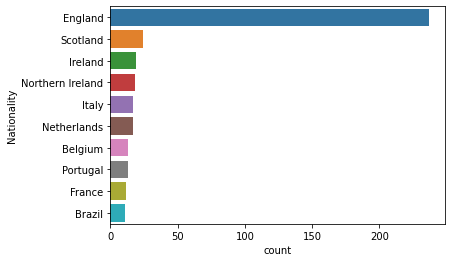

In [69]:
# b. Outgoing Transfers

ax = sns.countplot(y = "Nationality", data = mufc_v4.loc[(mufc_v4.Transfer_movement == "out") & (mufc_v4["Transfer type"] != "End of Loan")], order = mufc_v4.loc[(mufc_v4.Transfer_movement == "out") & (mufc_v4["Transfer type"] != "End of Loan"),"Nationality"].value_counts(ascending = False)[:10].index)

# Player Age Analysis

In [70]:
mufc_v4.groupby(["Transfer_movement","Transfer type"])["Age"].agg(['min','max','median'])

min   max  median
Transfer_movement Transfer type                         
in                End of Loan         18.0  34.0    21.0
                  Free Transfer       16.0  35.0    29.0
                  Loan Transfer       18.0  36.0    28.0
                  Permanent Transfer  15.0  36.0    23.0
out               End of Loan         19.0  37.0    27.0
                  Free Transfer       18.0  39.0    24.0
                  Loan Transfer       17.0  34.0    20.0
                  Permanent Transfer  19.0  37.0    24.0

In [71]:
# Oldest Player Mufc have paid a fee for:

mufc_v4.loc[(mufc_v4.Age == 36) & (mufc_v4["Transfer type"] == "Permanent Transfer") & (mufc_v4["Transfer_movement"] == "in")]

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude,Overall_Position,From_Club,To_Club
680,Manchester United,Cristiano Ronaldo,36.0,Centre-Forward,Juventus,Permanent Transfer,in,Summer,15.0,Premier League,2021,2021/2022,Portugal,Italy,Turin,45.10942,7.64101,Attack,Juventus,Manchester United


In [72]:
# Youngest Player Mufc have paid a fee for:

mufc_v4.loc[(mufc_v4.Age == 15 ) & (mufc_v4["Transfer type"] == "Permanent Transfer")& (mufc_v4["Transfer_movement"] == "in") ]

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude,Overall_Position,From_Club,To_Club
62,Manchester United,Kalam Mooniaruck,15.0,Left Winger,Norwich,Permanent Transfer,in,Summer,NaN,Premier League,1999,1999/2000,England,England,Norwich,52.622128,1.308653,Attack,Norwich,Manchester United


In [73]:
# Oldest Player Mufc have received a fee for:

mufc_v4.loc[(mufc_v4.Age == 37) & (mufc_v4["Transfer type"] == "Permanent Transfer") & (mufc_v4["Transfer_movement"] == "out")]

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude,Overall_Position,From_Club,To_Club
200,Manchester United,Bryan Robson,37.0,Central Midfield,Middlesbrough,Permanent Transfer,out,Summer,NaN,Premier League,1994,1994/1995,England,England,Middlesbrough,54.578333,-1.216944,Midfield,Manchester United,Middlesbrough


In [74]:
# Youngest Players Mufc have received a fee for:

mufc_v4.loc[(mufc_v4.Age == 19) & (mufc_v4["Transfer type"] == "Permanent Transfer") & (mufc_v4["Transfer_movement"] == "out")]

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude,Overall_Position,From_Club,To_Club
71,Manchester United,Richard Irving,19.0,Centre-Forward,Nottm Forest,Permanent Transfer,out,Summer,0.093,Premier League,1995,1995/1996,England,England,Nottingham,52.94,-1.132778,Attack,Manchester United,Nottm Forest
171,Manchester United,Keith Gillespie,19.0,Right Midfield,Newcastle,Permanent Transfer,out,Winter,1.500,Premier League,1994,1994/1995,Northern Ireland,England,Newcastle Upon Tyne,54.97525,-1.62213,Midfield,Manchester United,Newcastle
364,Manchester United,Jon Macken,19.0,Centre-Forward,Preston,Permanent Transfer,out,Summer,0.010,Premier League,1997,1997/1998,Ireland,England,Preston,53.77209,-2.68873,Attack,Manchester United,Preston
584,Manchester United,Kalam Mooniaruck,19.0,Left Winger,Braintree,Permanent Transfer,out,Summer,NaN,Premier League,2003,2003/2004,England,England,Braintree,51.87699,0.57007,Attack,Manchester United,Braintree
674,Manchester United,Andrew Taylor,19.0,Central Midfield,Northwich Vic,Permanent Transfer,out,Summer,NaN,Premier League,2002,2002/2003,England,England,Norwich,53.27048,-2.48919,Midfield,Manchester United,Northwich Vic


# Clubs that MUFC have done transfer business with

In [75]:
# Count of different clubs that MUFC has dealt with

mufc_v4["Club_involved_name"].nunique()

200

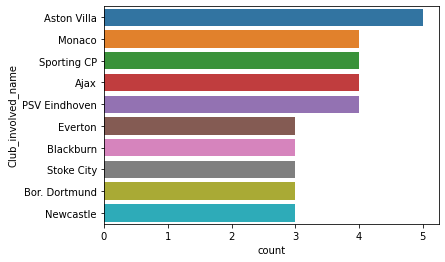

In [76]:
# 3. Which clubs has Mufc done the most number of transactions with?

# a. Incoming Transfers
ax = sns.countplot(y = "Club_involved_name", data = mufc_v4.loc[(mufc_v4.Transfer_movement == "in") & (mufc_v4["Transfer type"] != "End of Loan")], order = mufc_v4.loc[(mufc_v4.Transfer_movement == "in") & (mufc_v4["Transfer type"] != "End of Loan"),"Club_involved_name"].value_counts(ascending = False)[:10].index)

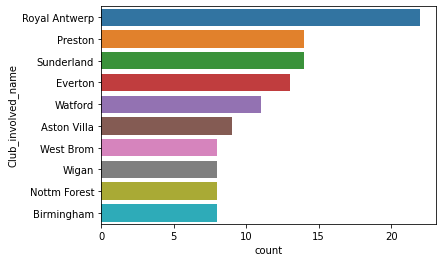

In [77]:
# b. Outgoing transfers

ax = sns.countplot(y = "Club_involved_name", data = mufc_v4.loc[(mufc_v4.Transfer_movement == "out") & (mufc_v4["Transfer type"] != "End of Loan")], order = mufc_v4.loc[(mufc_v4.Transfer_movement == "out") & (mufc_v4["Transfer type"] != "End of Loan"),"Club_involved_name"].value_counts(ascending = False)[:10].index)

# Transfer Fee Analysis

In [78]:
# Total Spend on Player Aquisitions:

total_spend = mufc_v4.loc[mufc_v4["Transfer_movement"] == "in","Fee(mill€)"].sum()
print("Total spend on player aquisitons in Million Euros :", "{:.3f}".format(total_spend))

Total spend on player aquisitons in Million Euros : 2364.660


In [79]:
# Total Player Sales in Million Euros:

total_sales = mufc_v4.loc[mufc_v4["Transfer_movement"] == "out","Fee(mill€)"].sum()
print("Total revenue from player sales in Million Euros :", "{:.3f}".format(total_sales))


Total revenue from player sales in Million Euros : 829.415


In [80]:
# Overall Net Spend in the Premier League by MUFC in Million Euros:

overall_net_spend = total_spend - total_sales
print("Overall Net Spend in Million Euros :", "{:.3f}".format(overall_net_spend))

Overall Net Spend in Million Euros : 1535.245


In [81]:
# Transfer fee aggregates by Season (*Fee has not been adjusted for inflation )

spend_by_season = mufc_v4.loc[mufc_v4["Transfer_movement"] == "in"].groupby(["Season"])["Fee(mill€)"].sum()
sales_by_season = mufc_v4.loc[mufc_v4["Transfer_movement"] == "out"].groupby(["Season"])["Fee(mill€)"].sum()
net_spend_season = spend_by_season - sales_by_season

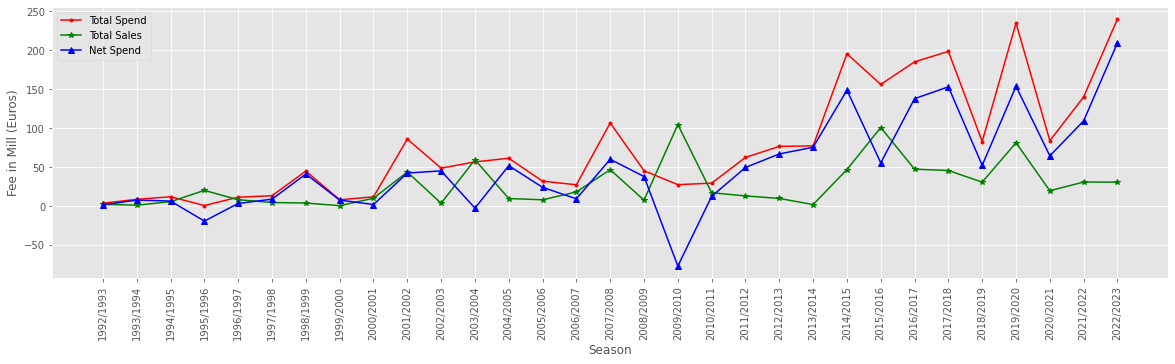

In [82]:
# Net Spend progression over the seasons:

plt.figure(figsize=(20, 5))

plt.style.use('ggplot')

plt.plot(spend_by_season.index,spend_by_season.values,marker='.', color='r', label= 'Total Spend')
plt.plot(sales_by_season.index,sales_by_season.values,marker='*', color='g', label= 'Total Sales')
plt.plot(net_spend_season.index,net_spend_season.values,marker='^', color='b', label= 'Net Spend')

plt.xticks(rotation = 90)
plt.xlabel("Season")
plt.ylabel("Fee in Mill (Euros)")
plt.legend()
plt.show()

In [83]:
# Overall Avg value for player sale and aquisition (not inclusive of loan fees)

sum_in = mufc_v4.loc[(mufc_v4["Transfer type"] == "Permanent Transfer") & (mufc_v4["Transfer_movement"] == "in"),"Fee(mill€)"].sum()
sum_out = mufc_v4.loc[(mufc_v4["Transfer type"] == "Permanent Transfer") & (mufc_v4["Transfer_movement"] == "out"),"Fee(mill€)"].sum()


num_buys = mufc_v4.loc[(mufc_v4["Transfer type"] == "Permanent Transfer") & (mufc_v4["Transfer_movement"] == "in"),"Transfer type"].value_counts()[0]
num_sales = mufc_v4.loc[(mufc_v4["Transfer type"] == "Permanent Transfer") & (mufc_v4["Transfer_movement"] == "out"),"Transfer type"].value_counts()[0]

print("Overall average value per Player Aquisition in Million Euros : ", "{:.3f}".format((sum_in / num_buys)))
print("Overall average value per Player Sales in Million Euros : ", "{:.3f}".format((sum_out / num_sales)))

Overall average value per Player Aquisition in Million Euros :  20.623
Overall average value per Player Sales in Million Euros :  6.908


In [84]:
# Avg fee of player sale and aquisition (permanent transfer only) progression over the seasons

num_tr_in = mufc_v4.loc[(mufc_v4["Transfer type"] == "Permanent Transfer") & (mufc_v4["Transfer_movement"] == "in")].groupby("Season")["Transfer type"].value_counts()
num_tr_out = mufc_v4.loc[(mufc_v4["Transfer type"] == "Permanent Transfer") & (mufc_v4["Transfer_movement"] == "out")].groupby("Season")["Transfer type"].value_counts()

avg_tr_in = spend_by_season / num_tr_in
avg_tr_out = sales_by_season / num_tr_out


# Resetting multi-index (Season, Transfer Type) to single index(Season)
avg_tr_in = avg_tr_in.to_frame().reset_index(level=[1]).drop(columns=["Transfer type"])
avg_tr_out = avg_tr_out.to_frame().reset_index(level=[1]).drop(columns=["Transfer type"])

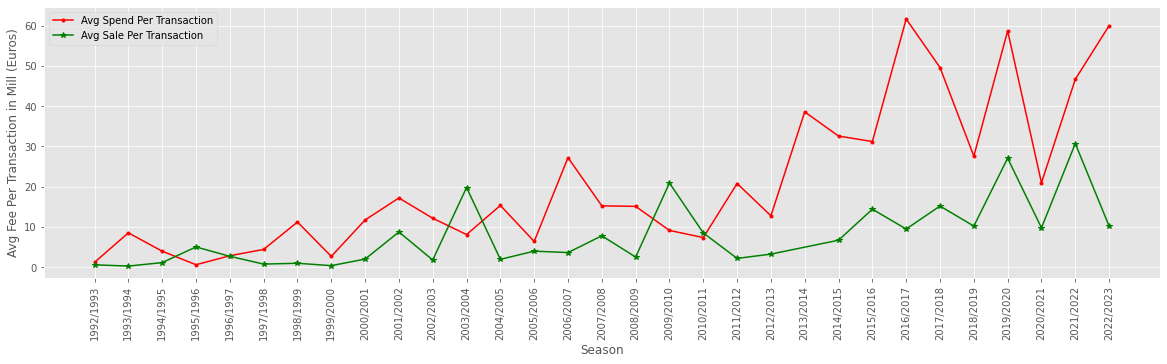

In [85]:
# Avg Player aquisition and sales fee progression by season:

plt.figure(figsize=(20, 5))

plt.plot(avg_tr_in.index,avg_tr_in.values,marker='.', color='r', label= 'Avg Spend Per Transaction')
plt.plot(avg_tr_out.index,avg_tr_out.values,marker='*', color='g', label= 'Avg Sale Per Transaction')

plt.xticks(rotation = 90)
plt.xlabel("Season")
plt.ylabel("Avg Fee Per Transaction in Mill (Euros)")
plt.legend()
plt.show()

In [86]:
# Top 5 Most Expensive Player Signings;

mufc_v4.loc[mufc_v4["Transfer_movement"] == "in"].sort_values(by = "Fee(mill€)", ascending = False).head()


,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude,Overall_Position,From_Club,To_Club
682,Manchester United,Paul Pogba,23.0,Central Midfield,Juventus,Permanent Transfer,in,Summer,105.0,Premier League,2016,2016/2017,France,Italy,Turin,45.10942,7.64101,Midfield,Juventus,Manchester United
836,Manchester United,Antony,22.0,Right Winger,Ajax,Permanent Transfer,in,Summer,95.0,Premier League,2022,2022/2023,Brazil,Netherlands,Amsterdam,52.31417,4.94222,Attack,Ajax,Manchester United
170,Manchester United,Harry Maguire,26.0,Centre-Back,Leicester,Permanent Transfer,in,Summer,87.0,Premier League,2019,2019/2020,England,England,Leicester,52.620278,-1.142222,Defence,Leicester,Manchester United
505,Manchester United,Jadon Sancho,21.0,Left Winger,Bor. Dortmund,Permanent Transfer,in,Summer,85.0,Premier League,2021,2021/2022,England,Germany,Dortmund,51.492569,7.451842,Attack,Bor. Dortmund,Manchester United
424,Manchester United,Romelu Lukaku,24.0,Centre-Forward,Everton,Permanent Transfer,in,Summer,84.7,Premier League,2017,2017/2018,Belgium,England,Liverpool,53.43817,-2.96651,Attack,Everton,Manchester United


In [87]:
# Top 5 Most Profitable Player Sales;

mufc_v4.loc[mufc_v4["Transfer_movement"] == "out"].sort_values(by = "Fee(mill€)", ascending = False).head()


,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude,Overall_Position,From_Club,To_Club
384,Manchester United,Cristiano Ronaldo,24.0,Centre-Forward,Real Madrid,Permanent Transfer,out,Summer,94.0,Premier League,2009,2009/2010,Portugal,Spain,Madrid,40.45306,-3.68835,Attack,Manchester United,Real Madrid
406,Manchester United,Romelu Lukaku,26.0,Centre-Forward,Inter,Permanent Transfer,out,Summer,74.0,Premier League,2019,2019/2020,Belgium,Italy,Milan,45.48591,9.1316,Attack,Manchester United,Inter
708,Manchester United,Angel Di Maria,27.0,Right Winger,Paris SG,Permanent Transfer,out,Summer,63.0,Premier League,2015,2015/2016,Argentina,France,Paris,48.841389,2.253056,Attack,Manchester United,Paris SG
382,Manchester United,David Beckham,28.0,Right Midfield,Real Madrid,Permanent Transfer,out,Summer,37.5,Premier League,2003,2003/2004,England,Spain,Madrid,40.45306,-3.68835,Midfield,Manchester United,Real Madrid
580,Manchester United,Henrikh Mkhitaryan,29.0,Attacking Midfield,Arsenal,Permanent Transfer,out,Winter,34.0,Premier League,2017,2017/2018,Armenia,England,North London,51.555,-0.108611,Midfield,Manchester United,Arsenal


# Tableau Visualization Steps

1. Used the output file ('mufc_analysis.csv') of this analysis as the input data source for Tableau.
2. The idea of the visualization project, is to create a hub and spoke map (contains origin, destination and connecting line) representation of all transfers carried out by Manchester United, with multiple filter options to easily narrow down the dataset. 
3. The stadium coordinates (Latitude,Longitude) of the club involved in the transfer are used as the origin point and stadium coordinates of Old Trafford have been used as the destination point. In tableau, the makepoint() and makeline() functions have been used to generate the connections between the two points.
4. The key challenge encountered during the visualization project, was the overlapping data points which made it difficult to visualize all the transfers (Ex. In the Summer window of 2022/2023 season, Manchester United have aquired two players (Antony and Lisandro Martinez) from Ajax - Netherlands. However, only one of the transfers shows up during visualization as the other data points are overlapped (as the origin points and destination points remain the same for both these transfers. Since there is no option in Tableau to alter the curvature of the line joining the two points, an alternative approach was required).
5. The solution used to handle this problem was to jitter overlapping points into a regular distribution around a center (Reference : https://community.tableau.com/s/news/a0A4T000001v7TOUAY/jitter-those-points)
6. The jittered latitude and longitude was then used as one of the parameters of the makeline function, which eliminated the issue of not being able to visualize overlapping points.
7. The final output is an interactive dashboard containing a hub and spoke representation of all transfers conducted by Manchester United (1992/1993 Season  - Present), with multiple filter options (Season, Player Nationality, Positions, Fee & Age Range, Transfer Type etc) for the user to breakdown the visualization.
 

# Summary of Findings

**Transfers**
- Overall, the club has completed 272 Loan Transfers (261 Outgoings & 11 Incoming)(Player returns and departures after end of loan spells not included), 230 Permanent Transfers (117 Outgoings  and 113 Incoming) and 115 Free Transfers (100 Outgoing and 15 Incoming).
- The club tends to loan out players a lot more than loaning them in. This corresponds to the club's policy of sending youth players out on loan for development(The median age of an outgoing loan player from the club in 20 years).
-  More transfer business is done is summer window (425) compared to winter window(198).

**Player Nationality and Age**
- Players featuring in the club's transfer business hail from 47 different countries.
- English players (32 Incoming & 240 Outgoings) top the list in terms of both incoming and outgoing transfers. Among Non-English Nations, the club has brought in players the most number of times from France (13) , Netherlands (11) and Brazil (7). Players from Scotland (24), Northern Ireland (19) and Republic of Ireland** feature among the top Non-English Nations in regards to outgoing transfers (Count is not limited to unique players. Same players transferred to multiple different clubs ( ex. multiple loans) is also taken into consideration).
- The oldest player for whom the club paid a fee for is Cristiano Ronaldo (Aged 36) from Juventus for a fee of 15 Million Euros in 2021. The youngest player for whom the club paid a fee for is Kalam Mooniaruck (Aged 15) from Norwich for an undisclosed sum in 1999.
- The oldest player for whom the club has received a fee for is Bryan Robson (Aged 40) who joined Middlesbrough F.C for an undisclosed sum in  1994.

**Clubs that MUFC have done Transfer Business with**
- The club has done transfer business with 200 clubs in total.
- The club have brought in the most number of players from Aston Villa - England (5), As Monaco - France, Sporting CP -Portugal, Ajax - Netherlands, PSV Eindhoven - Netherlands with 4 transfers each (count included loans, free transfers and permanent transfers)
- The club have transferred out the most number of players to Royal Antwerp - Belgium (22), Preston Noth End F.C - England (14) & Sunderland A.F.C - England (14). Royal Antwerp features prominently in this list as a result of a 1998 agreement with MUFC to act as a feeder club for the developent of young MUFC players looking for more gametime. Manchester United have also had a good relationship with Preston North End F.C with several youngsters joining the side in their developmental phase.

**Fee Aggregate Analysis**
- The club has spent ~ 2.36 Billion Euros in Player Aquistions (Permanent Transfers and Loan Fees) since the inception of the Premier League in 1992.
- The club has made ~ 830 Million Euros in Player Sales (Permanent Transfers and Loan Fees) since 1992.
- The net spend of the club stands at ~ 1.53 Billion Euros as of 2022.
- Overall (Premier League 1992 - 2022), the club spends an average of ~ 20 Million Euros to aquire a player and makes an average revenue of ~ 7 Mil on a player sale.

**Manchester United Transfers Visualized**

- https://public.tableau.com/app/profile/sasidharan4966/viz/ManchesterUnitedF_CPremierLeagueTransfersVisualized1992-Present/ManchesterUnitedTransferActivity

In [88]:
# Creating a unique tranfer_id for each transfer. This will help later on while creating a tableau visualization;

mufc_v4["Transfer_ID"] = [(n+1) for n in range(mufc_v4.shape[0])]

In [89]:
mufc_v4.head()

,Club_name,Player_name,Age,Position,Club_involved_name,Transfer type,Transfer_movement,Transfer_period,Fee(mill€),League_name,Year,Season,Nationality,Club_involved_country,Club_involved_location,Latitude,Longitude,Overall_Position,From_Club,To_Club,Transfer_ID
0,Manchester United,Dion Dublin,23.0,Centre-Forward,Cambridge Utd.,Permanent Transfer,in,Summer,1.5,Premier League,1992,1992/1993,England,England,Cambridge,52.21293,0.1568,Attack,Cambridge Utd.,Manchester United,1
1,Manchester United,Grant Brebner,20.0,Defensive Midfield,Cambridge Utd.,End of Loan,in,Winter,0.0,Premier League,1997,1997/1998,Scotland,England,Cambridge,52.21293,0.1568,Midfield,Cambridge Utd.,Manchester United,2
2,Manchester United,Grant Brebner,20.0,Defensive Midfield,Cambridge Utd.,Loan Transfer,out,Winter,0.0,Premier League,1997,1997/1998,Scotland,England,Cambridge,52.21293,0.1568,Midfield,Manchester United,Cambridge Utd.,3
3,Manchester United,Colin Heath,21.0,Centre-Forward,Cambridge Utd.,End of Loan,in,Winter,0.0,Premier League,2004,2004/2005,England,England,Cambridge,52.21293,0.1568,Attack,Cambridge Utd.,Manchester United,4
4,Manchester United,Colin Heath,20.0,Centre-Forward,Cambridge Utd.,Loan Transfer,out,Winter,0.0,Premier League,2004,2004/2005,England,England,Cambridge,52.21293,0.1568,Attack,Manchester United,Cambridge Utd.,5


In [90]:
mufc_v4.to_csv('mufc_analysis.csv', index = False)

# Future Improvements


1. Including League Info and Tier of League (within Country) of the clubs that Manchester United have done transfers with. This can help develop an understanding of how often the club recruits from less competitive and lower division leagues.
2. Adjusting transfer fees for inflation, to get a sense of what a player would be worth in today's transfer market.
3. Include additional information related to loan transfers (loan to buy options, loan with fee involved, loan duration etc).
4. Explanding this analysis to to include data from youth teams (can help us get a detailed idea of youth players going out on loan).
5. Improve code resuability aspect of this project, so that this analysis can be extended for other teams. In current project, many aspects such as country of club involved, club geo data, player nationality etc has been manually generated. This aspect could be improved in future iterations of the project through automated data generation features (web scraping).

*****************